In [ ]:
import sys
import time
from dataclasses import dataclass
import random as r
import numpy as np
from functools import partial
from matplotlib import pyplot as plt
from sentencepiece import SentencePieceProcessor
import os; import glob
import requests
from typing import Callable, Sequence, Any
import functools; import operator
from tqdm import tqdm
import pickle

import jax
from jax import (
    Array,
    numpy as jnp,
    random as jrand
)
try:
    from flash_attn_jax import flash_mha
    USE_FLASH_ATT = True
except:
    USE_FLASH_ATT = False
import keras as nn; nn.utils.set_random_seed(42)
nn.mixed_precision.set_dtype_policy("mixed_bfloat16")
import torch

print("Python Version", sys.version); del sys
print(f"Keras Version {nn.__version__} with {nn.backend.backend()} backend \tJax Version {jax.__version__}")
print("Jax backend device", jax.default_backend())
print("PyTorch version:", torch.__version__)

# Tokenizer

In [ ]:
TOKENIZER_PATH = "sentence_piece_512.model"
spm = SentencePieceProcessor(model_file=TOKENIZER_PATH)
VOCAB_SIZE = spm.vocab_size(); print(VOCAB_SIZE)
SOS = spm.bos_id()
print(spm.Decode(spm.Encode("Hey hi!!!")), spm.Encode("Hey hi!!!"))

# Dataset

In [ ]:
DATA_CACHE_DIR = "data/TinyStories"
TRAIN_FILE_PATH = os.path.join(DATA_CACHE_DIR, "train.txt")
VAL_FILE_PATH = os.path.join(DATA_CACHE_DIR, "val.txt")

SHARD_DIR = os.path.join(DATA_CACHE_DIR, f"tok{VOCAB_SIZE}")

## File Utils

In [ ]:
def download_file(url:str, filename:str, chunk_size:int=1024):
    """Download a file from the given URL and save it with the specified filename"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(filename, "wb") as file, tqdm(
        desc=filename,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

    print(f"{filename} downloaded successfully:")

## Data

In [ ]:
def download():
    "download if train file not present and data dir is empty"
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)

    urls = ["https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt",
            "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-valid.txt"]
    file_paths = [TRAIN_FILE_PATH, VAL_FILE_PATH]

    if (not os.listdir(DATA_CACHE_DIR)):
        # download files
        for url, file_path in zip(urls, file_paths):
            if (not os.path.exists(file_path)):
                download_file(url, file_path)
    else:
        print(f"{file_paths[0]} is present. Skipping download.")

In [ ]:
download() # ~8mins to download

## Pretokenize, Shard and Load Data Functions

In [ ]:
def pretokenize_and_save_dataset(train_ds_path:str, val_ds_path:str, num_shards:int):
    if glob.glob(os.path.join(SHARD_DIR, "*.npy")):
        print("Dataset is already pretokenized.")
    else:
        print("Pretokenizing dataset...")
        dataset = open(train_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")
        val_dataset = open(val_ds_path, "r", encoding="utf-8").read().split("<|endoftext|>")

        dataset = dataset + val_dataset; del val_dataset
        dataset = list(map(str.strip, dataset))
        dataset:list = spm.Encode(
                dataset,
                add_bos=True,
                add_eos=False
            ) # [[SOS story], ..., [SOS story]]
        print("Dataset:")
        print("\tNumber of stories:", len(dataset))

        # flatten
        dataset = functools.reduce(operator.iconcat, dataset, [])
        num_tokens = len(dataset); print("\tNumber of tokens in the dataset:", num_tokens)
        print("\tNumber of unique tokens in the dataset:", len(set(dataset)))
        
        dataset = np.asarray(dataset, dtype=np.uint16) # [SOS story ... SOS story]
        print("\tAvg length of story:", num_tokens/((dataset==SOS).sum()))

        # shard and save dataset
        sharded_datasets_list = np.array_split(dataset, num_shards) # [[SOS story...], [...], [...], ...]
        filenames = [os.path.join(SHARD_DIR, f"shard{i+1}.npy") for i in range(num_shards)]
        
        for filename, sharded_ds in tqdm(zip(filenames, sharded_datasets_list), total=len(filenames), desc="Saving pretokenized shards"):
            with open(filename, "wb") as f:
                np.save(f, sharded_ds)
        print("Done.")


class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, split:str, maxlen:int, seed:int=42):
        self.split = split
        self.maxlen = maxlen
        
        os.makedirs(SHARD_DIR, exist_ok=True)
        self.shard_filepaths = glob.glob(os.path.join(SHARD_DIR, "*.npy"))
        self.r = r.Random(seed)

    def __iter__(self):
        split_shard_filepaths = self.shard_filepaths[:-1] if self.split == "train" else self.shard_filepaths

        while True:
            self.r.shuffle(split_shard_filepaths)
            for shard in split_shard_filepaths:
                m:np.ndarray = np.load(shard, mmap_mode="r")

                num_batches = len(m)//self.maxlen
                num_batches -= 1 # drop remainder
                assert num_batches > 0, "Number of batches should be greater than 0. Investigate..."

                ixs = list(range(num_batches))
                self.r.shuffle(ixs)

                for ix in ixs:
                    start = ix*self.maxlen
                    end = start + self.maxlen + 1

                    chunk = torch.from_numpy(m[start:end].astype(dtype=np.int64))
                    x = chunk[:-1]
                    y = chunk[1:]
                    yield x, y


class BatchedDataset:
    @staticmethod
    def iter_ds(batch_size, device, num_workers=0, **ds_kwargs):
        ds = torch.utils.data.DataLoader(
            IterDataset(**ds_kwargs), batch_size=batch_size, pin_memory=True,
            num_workers=num_workers
        )

        for x, y in ds:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            yield x, y

# GPT

## Positional Embeddings

In [ ]:
class PositionalEmbedding:
    """```
    Sinusoidal Fixed Positional Embeddings
    Args:
        maxlen:int
        dim:int
    sinusoidal_embeddings: 
        pos_emb: (1, maxlen, dim)
    get_freqs:
        get_freqs: sin_freqs(1, maxlen, 1, dim), cos_freqs(1, maxlen, 1, dim)
    ```"""
    def __init__(self, maxlen:int, dim:int):
        p, i = jnp.meshgrid(jnp.arange(float(maxlen)), jnp.arange(dim/2)*2)
        theta = (p/1e4**(i/dim)).T
    
        self.pos_emb = jnp.stack([jnp.sin(theta), jnp.cos(theta)], axis=-1)
        self.pos_emb = self.pos_emb.reshape((maxlen, dim))[None] # (1, maxlen, dim)
    
    def sinusoidal_embeddings(self):
        return self.pos_emb # (1, maxlen, dim)
    
    def get_freqs(self):
        sin_freqs = self.pos_emb[..., None, ::2].repeat(2, axis=-1)
        cos_freqs = self.pos_emb[..., None, 1::2].repeat(2, axis=-1)
        return sin_freqs, cos_freqs # (1, maxlen, 1, dim), (1, maxlen, 1, dim)

## Attention

In [ ]:
class Attention(nn.Layer):
    """```
    Multi-head Attention
    Args:
        causal:bool
        config
    Input:
        x: shape(B, N, d_model)
        training: bool
    Output:
        linear_att_out: shape(B, N, d_model)
    ```"""
    def __init__(
            self,
            causal:bool,
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        assert config.d_model % config.num_heads == 0
        self.flash = config.use_flash_att
        self.causal = causal
        self.num_heads = config.num_heads
        self.dim = config.d_model//config.num_heads

        self.wq = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wk = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.wv = nn.layers.Dense(config.d_model, use_bias=False, kernel_initializer=config.intializer(std=0.02))
        self.dropout = nn.layers.Dropout(config.dropout_rate)

        self.wo = nn.layers.Dense(
            config.d_model,
            use_bias=config.use_bias,
            kernel_initializer=config.intializer(std=0.02/(2*config.num_layers)**0.5)
        )
        if causal and (not config.use_flash_att): # when causal and not using flash att
            self.causal_mask = jnp.triu(jnp.full(shape=(1, 1, config.maxlen, config.maxlen), fill_value=-jnp.inf), k=1)

    def call(
            self,
            x:Array, # (B, T, d_model)
            training:bool
    ):
        B, T, d_model = x.shape

        # compute q, k, v
        q = self.wq(x) # (B, T, d_model)
        k = self.wk(x) # (B, T, d_model)
        v = self.wv(x) # (B, T, d_model)
        
        # compute attention weights
        if self.flash:
            shape = (B, T, self.num_heads, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, T, h, dim)
            att_out = flash_mha(q, k, v, softmax_scale=None, is_causal=self.causal) # (B, T, h, dim)
        else:
            shape = (B, self.num_heads, T, self.dim)
            q, k, v = q.reshape(shape), k.reshape(shape), v.reshape(shape) # (B, h, T, dim)
            att_wei = (q @ jnp.matrix_transpose(k))/self.dim**0.5 # (B, h, T, T) <= (B, h, T, dim) @ (B, h, T, dim).transpose(2, 3)
            # causal mask
            if self.causal:
                att_wei += self.causal_mask[:, :, :T, :T] # (B, h, T, T)
            att_wei = jax.nn.softmax(att_wei, axis=-1) # (B, h, T, T)
            # apply attention weights to v
            att_out = att_wei @ v # (B, h, T, T) @ (B, h, T, dv) => (B, h, T, dv)

        # combine heads
        att_out = att_out.reshape((B, T, d_model)) # (B, T, h*dim) ==> (B, T, d_model)

        # linear of att_out
        linear_att_out = self.wo(att_out)
        linear_att_out = self.dropout(linear_att_out, training=training) # (B, T, d_model)
        return linear_att_out

## Block

In [ ]:
class TransformerBlock(nn.Model):
    """```
    TransformerBlock
    Args:
        causal:bool
        config
    Inputs: 
        inputs: shape(B, T, d_model)
        pad_mask: shape(B, T) of boolean dtype
    Outputs:
        outputs: shape(B, T, d_model)
    ```"""
    def __init__(
            self, 
            causal:bool, 
            config,
            **kwargs
    ):
        super().__init__(**kwargs)
        dff_in = 4*config.d_model
        self.norm1 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        self.mha = Attention(causal, config)

        self.ffn = nn.Sequential([
            nn.layers.Dense(int(dff_in), use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Activation(lambda x: nn.activations.gelu(x, approximate=True)),
            nn.layers.Dense(config.d_model, use_bias=config.use_bias, kernel_initializer=config.intializer(std=0.02)),
            nn.layers.Dropout(config.dropout_rate)
        ])
        self.norm2 = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
    def call(self, x:Array, training:bool):
        z = x + self.mha(self.norm1(x), training=training)
        y = z + self.ffn(self.norm2(z), training=training)
        return y # (B, T, d_model)

In [ ]:
def build_model(model:nn.Model, input_shape:tuple, val_intervals:tuple):
    blabla = model(
        jrand.randint(jrand.PRNGKey(32344), shape=input_shape, minval=val_intervals[0], maxval=val_intervals[-1]), training=True
    ); del blabla
    return model

class TieWeights(nn.Layer):
    def __init__(self, Layer:nn.Layer, bias_units:int|None, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.Layer = Layer # weights of (1, vocab_size, d_model)
        self.use_bias = bool(bias_units)
        self.activation = nn.layers.Activation(nn.activations.get(activation), dtype=kwargs["dtype"])
        
        if self.use_bias:
            self.bias = self.add_weight(shape=(bias_units,), initializer="zeros", trainable=True)
        
    def call(self, x): # (B, T, d_model)
        W = jnp.array(self.Layer.weights)[0] # (vocab_size, d_model)
        z = x @ jnp.matrix_transpose(W) # (B, T, vocab_size)
        if self.use_bias:
            z += self.bias
        return self.activation(z)

## Transformer

In [ ]:
class Transformer(nn.Model):
    """```
    Decoder Transformer!!
    Args:
        causal:bool
        config:
            d_model: int
            num_heads: int
            num_layers: int
            maxlen: int
            vocab_size: int
            output_units: int => if None is equal to vocab_size
            use_bias:bool,
            dropout_rate: float
        output_activation:str
    Inputs:
        inputs: shape(B, T)
    Outputs: 
        outputs: shape(B, T, d_model)    
    ```"""
    def __init__(self, causal:bool, config, output_activation:str=None, **kwargs):
        super().__init__(**kwargs)
        if config.output_units is None:
            config.output_units = config.vocab_size
        # pos embedding
        self.pos_embed = PositionalEmbedding(config.maxlen, config.d_model).sinusoidal_embeddings() # (1, maxlen, d_model)
        # embedding tokens and dropout
        self.emb_dropout = nn.layers.Dropout(config.dropout_rate)
        self.token_embed = nn.layers.Embedding(
            config.vocab_size,
            config.d_model,
            embeddings_initializer=config.intializer(std=0.02)
        )

        # block layers
        self.block_layers = [
                TransformerBlock(
                    causal=causal, 
                    config=config
                ) for _ in range(config.num_layers)
            ]

        # final layer: outputs logits with dropout
        self.norm = nn.layers.LayerNormalization(epsilon=1e-5, rms_scaling=not config.use_bias)
        
        self.linear = TieWeights(
            self.token_embed,
            bias_units=None if config.use_bias is False else config.output_units,
            activation=output_activation,
            dtype="float32"
        )

    def call(
            self, 
            inputs:Array,
            training=False
    ):
        # embed tokens
        x = self.emb_dropout(
            self.token_embed(inputs)+self.pos_embed[:, :inputs.shape[-1], :], training=training
        ) # (B, T) ==> (B, T, d_model) # (B, T) ==> (B, T, d_model)
        
        # block layers
        for layer in self.block_layers:
            x = layer(x, training=training) # (B, T, d_model) ==> (B, T, d_model)
        x = self.norm(x)

        # linear layer: outputs logits
        logits = self.linear(x) # (B, T, d_model) ==> (B, T, vocab_size)
        return logits

# GPT Configuration

In [ ]:
@dataclass
class GPTConfig:
    """GPT 280K Configuration"""
    use_flash_att:bool=USE_FLASH_ATT
    d_model:int = 64
    num_layers:int = 5
    num_heads:int = 8
    maxlen:int = 512
    vocab_size:int = VOCAB_SIZE
    output_units:int = None
    assert d_model % 2 == 0
    assert d_model % num_heads == 0
    dropout_rate:float = 0.0
    use_bias:bool = True
    intializer:Callable = lambda std: nn.initializers.RandomNormal(mean=0.0, stddev=std)

GPTConfig()

# Loss vs Learning Rate

```python
def LossvsLR(): # (B, maxlen)
    model = build_model(
        Transformer(causal=True, config=GPTArgs), 
        (2, GPTArgs.max_context_length), 
        (0, GPTArgs.vocab_size-1)
        )
    inputs = jrand.randint(jrand.PRNGKey(32344), shape=(2, GPTArgs.max_context_length+1), minval=0, maxval=GPTArgs.vocab_size-1)

    def get_loss(lr, model, inputs):
        x, y = inputs[:, :-1], inputs[:, 1:]
        model.compile(
            optimizer=nn.optimizers.AdamW(
                learning_rate=lr, beta_1=0.9, beta_2=0.95, clipvalue=1e0, weight_decay=1e-1),
            loss=nn.losses.SparseCategoricalCrossentropy(from_logits=True)
        )
        loss = model.train_on_batch(x=x, y=y)
        return loss.tolist()
    
    lrs = (10**jnp.linspace(-6, -2, 100)).tolist()
    losses = [get_loss(lr, model, inputs) for lr in lrs]
    # losses = jax.vmap(get_loss, in_axes=(None, 0))(model, lrs)
    return lrs, losses
```

# Training Arguments

In [ ]:
@dataclass
class TArgs:
    # lr scheduler
    init_lr:float = 1e-7
    max_lr:float = 1e-3
    min_lr:float = 0.0*max_lr # The factor is usually 0.1 or 0.0
    num_steps:int = 100_000
    warmup_steps:int = 1000
    decay_steps:int = num_steps

    # optimizer
    beta1:float = 0.9
    beta2:float = 0.9759
    weight_decay:float = 1e-2
    clipnorm:float = 1e0
    num_grad_accumalation_steps:int = 1
    ## num_tok_per_update = batch_size * maxlen * gradient_accumalation = 128 * 256 * 1 = 32_768

    # training
    checkpoint_dir:str = "weights/stories512"
    eval_freq:int = 2000
    eval_steps:int = 100
    batch_size:int = 128 # mini-batch_size if num_grad_accumalation_steps > 1
    ## early stopping with restore best weights, keeping it very high to see if training improves later
    patience:int = 15

TArgs()

# Model

In [ ]:
model = Transformer(causal=True, config=GPTConfig, output_activation=None)
model = build_model(model, (2, GPTConfig.maxlen), (0, GPTConfig.vocab_size-1))
model.summary()

# Load data

In [ ]:
pretokenize_and_save_dataset(TRAIN_FILE_PATH, VAL_FILE_PATH, num_shards=50)

ds_iterater = partial(
    BatchedDataset.iter_ds,
    batch_size=TArgs.batch_size,
    device="cpu",
    num_workers=0,
    maxlen=GPTConfig.maxlen,
    seed=42
)
train_iterator, val_iterator = (
    ds_iterater(split="train"),
    ds_iterater(split="val")
)

# Lr schedule

In [ ]:
learning_rate = nn.optimizers.schedules.CosineDecay(
    initial_learning_rate=TArgs.min_lr,
    decay_steps=TArgs.decay_steps,
    warmup_steps=TArgs.warmup_steps,
    warmup_target=TArgs.max_lr,
    alpha=TArgs.min_lr/TArgs.max_lr
)

steps = jnp.arange(1, TArgs.num_steps+1)
lrs = jax.vmap(learning_rate)(steps)

plt.plot(steps, lrs)
plt.grid(True)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs Steps")
plt.xticks(range(0, TArgs.num_steps+10_000, 10_000), rotation=20)
plt.yticks(jnp.arange(0, TArgs.max_lr+1e-4, 1e-4).tolist())
plt.show(); del steps, lrs

# Save and Load model

In [ ]:
def save_object(dir_suffix_ftype:str, obj:Any):
    """
    dir_suffix_ftype: directory suffix and file type separated by "|"
    obj: Anything which is to be stored
    """
    dir, suffix, ftype = dir_suffix_ftype.split("|"); path = os.path.join(dir, "".join([suffix, f".{ftype}"]))
    os.makedirs(name=dir, exist_ok=True)
    with open(path, "wb") as file:
        pickle.dump(obj=obj, file=file, protocol=pickle.HIGHEST_PROTOCOL)
    return path

In [ ]:
def load_object(path:str):
    with open(path, "rb") as file:
        obj = pickle.load(file)
    return obj

# Training

* Segregate trainable variables for building different optimizers
* Again combine them in the same order as it was (before segregating them) for `model.stateless_call`
* Segregate trainable variables for optimization of trainable variables for different optimizers

In [ ]:
class ParamGradManager:
    def __init__(self, trainable_vars:list):
        order_before_segregate = [v.path for v in trainable_vars]
        order_after_segregate = (
            [v.path for v in trainable_vars if len(v.shape)!=1] +
            [v.path for v in trainable_vars if len(v.shape)==1]
        )
        self.idx = [order_after_segregate.index(b) for b in order_before_segregate]
    
    def filter_obj(self, trainable_obj:list):
        """
        filter `trainable_obj` into `decay_obj` and `nodecay_obj`\n
        `obj` can be params or grads
        """
        decay_obj = [v for v in trainable_obj if len(v.shape)!=1]
        nodecay_obj = [v for v in trainable_obj if len(v.shape)==1]
        return decay_obj, nodecay_obj
    
    def combine_obj(self, decay_obj:list, nodecay_obj:list):
        """
        combine `decay_obj` and `nodecay_obj` into `obj`\n
        `obj` can be params or grads
        """
        obj = decay_obj + nodecay_obj
        return [obj[i] for i in self.idx]

In [ ]:
adamw = lambda weight_decay: nn.optimizers.AdamW(
        learning_rate=learning_rate,
        beta_1=TArgs.beta1,
        beta_2=TArgs.beta2,
        clipnorm=TArgs.clipnorm,
        weight_decay=weight_decay
)
decay_optimizer = adamw(weight_decay=TArgs.weight_decay)
nodecay_optimizer = adamw(weight_decay=0.0)
loss_fn = nn.losses.SparseCategoricalCrossentropy(from_logits=True)

@jax.jit
def get_accuracy(y_true:Array, logits:Array): # (B, T), (B, T, vocab_size)
    batched_num_correct = (logits.argmax(-1)==y_true).sum(-1)/y_true.shape[-1] # (B,)
    accuracy = batched_num_correct.mean()
    return accuracy

@jax.jit
def compute_loss(
        trainable_vars:list, 
        non_trainable_vars:list, 
        X_batch:Array, y_batch:Array, 
        num_grad_accumalation_steps:int
    ):
    logits, non_trainable_vars = model.stateless_call(
        trainable_vars,  non_trainable_vars,
        X_batch)
    loss = loss_fn(y_batch, logits)
    accuracy = get_accuracy(y_batch, logits)
    unscaled_loss = loss/num_grad_accumalation_steps
    # scaled_loss = optimizer.scale_loss(unscaled_loss)
    return unscaled_loss, (unscaled_loss, accuracy, non_trainable_vars)
grad_fn = jax.value_and_grad(compute_loss, has_aux=True)

@partial(jax.jit, static_argnums=-1)
def mini_step(train_state:Sequence[list], X_batch:Array, y_batch:Array, num_grad_accumalation_steps:int):
    trainable_vars, non_trainable_vars = train_state

    (_, aux), grad = grad_fn(
        trainable_vars, non_trainable_vars, X_batch, y_batch,
        num_grad_accumalation_steps
    )
    (unscaled_loss, accuracy, non_trainable_vars) = aux
    return grad, (unscaled_loss, accuracy), (trainable_vars, non_trainable_vars)

def optimizer_apply(optimizer, opt_vars, grads, trainable_vars):
    trainable_vars, opt_vars = optimizer.stateless_apply(opt_vars, grads, trainable_vars)
    return trainable_vars, opt_vars

decay_opt_apply = jax.jit(fun=lambda opt_vars, grads, trainable_vars: optimizer_apply(decay_optimizer, opt_vars, grads, trainable_vars))
nodecay_opt_apply = jax.jit(fun=lambda opt_vars, grads, trainable_vars: optimizer_apply(nodecay_optimizer, opt_vars, grads, trainable_vars))

def update_params(
    grads:list,
    trainable_vars:list,
    optimizer_vars:tuple[list, list],
    param_grad_manager:ParamGradManager
):
    decay_grads, nodecay_grads = param_grad_manager.filter_obj(grads)
    decay_trainable_vars, nodecay_trainable_vars = param_grad_manager.filter_obj(trainable_vars)
    decay_opt_vars, nodecay_opt_vars = optimizer_vars
    
    decay_trainable_vars, decay_opt_vars = decay_opt_apply(
        decay_opt_vars, decay_grads, decay_trainable_vars
    )
    nodecay_trainable_vars, nodecay_opt_vars = nodecay_opt_apply(
        nodecay_opt_vars, nodecay_grads, nodecay_trainable_vars
    )
    trainable_vars1 = param_grad_manager.combine_obj(decay_trainable_vars, nodecay_trainable_vars)
    assert [v.shape for v in trainable_vars1] == [v.shape for v in trainable_vars], f"train vars aft: {[v.shape for v in trainable_vars1]}\n\ntrain vars bef: {[v.shape for v in trainable_vars]}"
    return trainable_vars1, (decay_opt_vars, nodecay_opt_vars)

def evaluate(train_state:Sequence[list]):
    trainable_vars, non_trainable_vars = train_state
    mean_losses = []; mean_accuracies = []
    for eval_batch_iter in [train_iterator, val_iterator]:
        X_batch, y_batch = next(eval_batch_iter)
        losses = jnp.empty(TArgs.eval_steps)
        accuracies = jnp.empty_like(losses)

        for eval_step in range(TArgs.eval_steps):
            _, (unscaled_loss, accuracy, non_trainable_vars) = compute_loss(
                trainable_vars, non_trainable_vars,
                jnp.array(X_batch), jnp.array(y_batch), 1
            )
            losses = losses.at[eval_step].set(unscaled_loss)
            accuracies = accuracies.at[eval_step].set(accuracy)
            X_batch, y_batch = next(eval_batch_iter)
        mean_losses.append(losses.mean())
        mean_accuracies.append(accuracies.mean())
    return mean_losses, mean_accuracies # ([train_loss, val_loss], [train_accuracy, val_accuracy])

In [ ]:
def train(return_best_train_states=True):
    step = 1; wait = 0
    training_losses = {"train": []}

    trainable_vars = model.trainable_variables
    param_grad_manager = ParamGradManager(trainable_vars)
    for param, opt in zip(param_grad_manager.filter_obj(trainable_vars), [decay_optimizer, nodecay_optimizer]):
        opt.build(param)
    non_trainable_vars = model.non_trainable_variables
    decay_opt_vars, nodecay_opt_vars = decay_optimizer.variables, nodecay_optimizer.variables

    best_step = 1
    best_ckpt = (trainable_vars, non_trainable_vars, (decay_opt_vars, nodecay_opt_vars))
    best_val_loss = 1e8

    t0 = time.time()
    print("Training about to start...")
    X_batch, y_batch = next(train_iterator)
    # TODO: Optimize Train Loop to reduce time per step
    while True:
        lr = learning_rate(step)
        # condition to terminate
        if step > TArgs.num_steps or wait > TArgs.patience:
            print(f"Early Stopping at Step {step}." if wait > TArgs.patience else "Training Terminated.")
            break
        
        # train model
        grads = jax.tree_util.tree_map(jnp.zeros_like, trainable_vars)
        for _ in range(TArgs.num_grad_accumalation_steps):
            grad, (loss, accuracy), (trainable_vars, non_trainable_vars) = mini_step(
                (trainable_vars, non_trainable_vars),
                jnp.array(X_batch), jnp.array(y_batch),
                TArgs.num_grad_accumalation_steps
            )
            grads = jax.tree_util.tree_map(
                lambda g1, g2: jnp.add(g1, g2), grads, grad
            ) # sum grads for grad accumation
            X_batch, y_batch = next(train_iterator)
        grad = None # save memory

        loss = loss*TArgs.num_grad_accumalation_steps # loss from last mini-step

        trainable_vars, (decay_opt_vars, nodecay_opt_vars) = update_params(
            grads, trainable_vars, (decay_opt_vars, nodecay_opt_vars),
            param_grad_manager=param_grad_manager
        )
        grads = None # save memory

        if step % TArgs.eval_freq == 0 or step == TArgs.num_steps:
            print("Estimating Losses...")
            mean_losses, mean_accuracies = evaluate((trainable_vars, non_trainable_vars))
            print(
                f"\t| Training Loss: {mean_losses[0]:.4f} || Training Accuracy: {mean_accuracies[0]:.4f} |" 
                f"| Validation Loss: {mean_losses[1]:.4f} || Validation Accuracy: {mean_accuracies[1]:.4f} |"
            )

            if mean_losses[1] < best_val_loss:
                best_val_loss = mean_losses[1]
                best_ckpt = (trainable_vars, non_trainable_vars, (decay_opt_vars, nodecay_opt_vars))
                best_step = step
                wait = 0

                save_object(
                    TArgs.checkpoint_dir+f"|checkpoint|gpt",
                    obj=best_ckpt
                )
                print(f"Saved checkpoint of step {step}.")
            else:
                wait += 1

        # time
        t1 = time.time()
        dt = t1-t0; t0 = t1

        # print the essentials
        print(
            f"| Step: {step} || Loss: {loss:.4f} || Accuracy: {accuracy:.4f} |"
            f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |"
        )
        training_losses["train"].append(loss.tolist())
        step += 1

    if return_best_train_states:
        print(f"Best Weights are from Step {best_step}")
        print("With an Estimated Validation Loss of", best_val_loss)
        return best_ckpt[:-1], training_losses
    
    return (trainable_vars, non_trainable_vars), training_losses

In [ ]:
best_train_state, losses = train(return_best_train_states=True) # 89.77833mins
# clear outputs as it's very long

```python
Training Terminated.
Best Weights are from Step 76000
With an Estimated Validation Loss of 1.3321948
```
63.84%

In [ ]:
_ = save_object(
        TArgs.checkpoint_dir+f"|trstate_1|weights",
        obj=best_train_state
    )

In [ ]:
plt.plot(losses["train"])
plt.title("Training Loss over Number of Steps")
plt.xlabel("Steps")
plt.ylabel("Train Loss")
plt.yticks(jnp.arange(0, 7, 0.3).tolist())
plt.xticks(range(0, TArgs.num_steps+3_000, 3_000), rotation=90)
plt.grid(True)
plt.show()

### When beta_2 (momentum was 0.99)
* 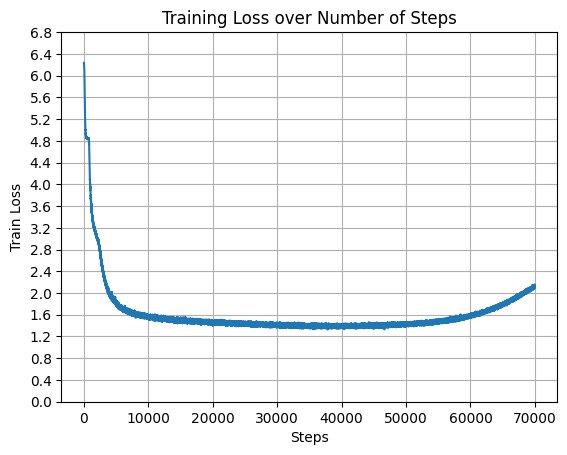
* Loss starts to increase after 50k steps due to high momentum, changing it to 0.9759 solved the problem and got a bit better result
* And also I decreased weight decay from 1e-1 to 1e-4, maybe that also contributed to solving the problem

### With beta_2=0.9759 and weight decay=1e-4
* 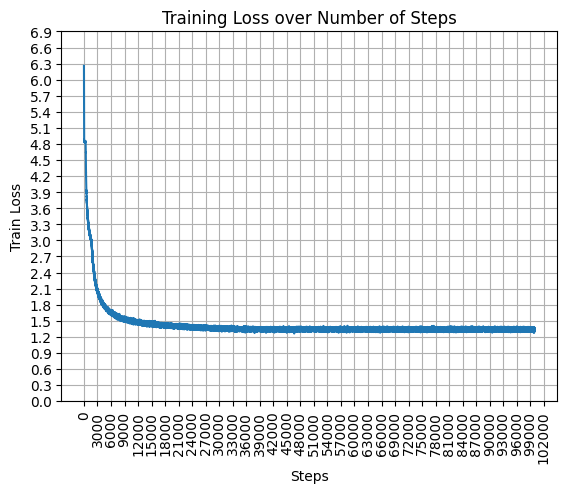
    ```python
    Training Terminated.
    Best Weights are from Step 76000
    With an Estimated Validation Loss of 1.3343884
    ```

### With beta_2=0.9759 and weight_deacy=0.0 (We got this graph above)
* 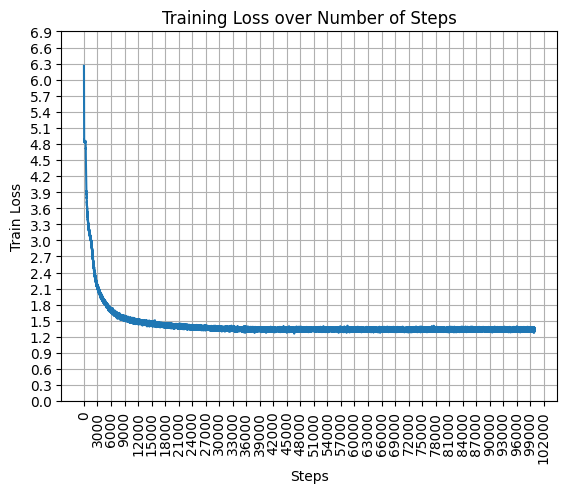
    ```python
    Training Terminated.
    Best Weights are from Step 76000
    With an Estimated Validation Loss of 1.3321948
    ```    

### With beta_2=0.99 and weight_deacy=0.0
* ...

# Sampling from model

In [ ]:
class GenerateTokens:
    def __init__(self, model:nn.Model, train_state:Sequence[list], maxlen:int, sos:int):
        self.SOS = jnp.array([[sos]])
        self.model = model
        self.train_state = train_state
        self.maxlen = maxlen
    
    @staticmethod
    @jax.jit
    def randCategorical(key:Array, logits:Array):
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted; does it speed up code?
    # @partial(jax.jit, static_argnums=-1)
    def topK(key:Array, logits:Array, k:Array):
        if jnp.where(k==1, True, False):
            idx_next = logits.argmax(-1, keepdims=True)
            return idx_next
        logits, topK_idx = jax.lax.top_k(logits, k=k)
        idx = jrand.categorical(key, logits)
        idx_next = topK_idx[0][idx][..., None]
        return idx_next # (1, 1)

    @staticmethod
    # TODO(VachanVY): Debug when jitted; does it speed up code?
    # @partial(jax.jit, static_argnums=(-1, -2))
    def topP(key:Array, logits:Array, p:float, k:int|None=None):
        probs = jax.nn.softmax(logits, axis=-1)
        # reverse arg sort of probs
        rev_argsort_prob_idx = jnp.argsort(probs)[:, ::-1]
        # True bools of idx less than p that sum less than p || False bool of least idxs that sum more than p
        less_than_p_bools = (jnp.cumsum(probs.take(rev_argsort_prob_idx), axis=-1) <= p)

        # idx from which to mask
        mask_from_id = less_than_p_bools.sum()+1
        # idxs to mask
        mask_idx = rev_argsort_prob_idx[:, mask_from_id:]
        # -inf masked idx won't be sampled 
        logits = logits.at[:, mask_idx].set(-jnp.inf)

        if k is not None:
            key, _ = jrand.split(key)
            idx_next = GenerateTokens.topK(key, logits, k)
            return idx_next # (1, 1)
        
        idx_next = jrand.categorical(key, logits)[..., None]
        return idx_next # (1, 1)

    @partial(jax.jit, static_argnums=0)
    def get_logits(self, idx_cond:Array, trainable_variables:list, non_trainable_variables:list):
        logits, non_trainable_variables = self.model.stateless_call(
            trainable_variables, non_trainable_variables, idx_cond
        )
        return logits[:, -1, :], non_trainable_variables

    def generate(self, idx:Array, max_tok:int=500, top_k:int|None=None, top_p:float|None=None,  temp:float=0.8, seed:int=42):
        trainable_variables, non_trainable_variables = self.train_state
        if (not top_k) and (not top_p):
            sampleTok = GenerateTokens.randCategorical
        elif (top_k is not None) and (top_p is not None):
            sampleTok = lambda key, logits: GenerateTokens.topP(key, logits, top_p, top_k)
        elif top_k is not None:
            sampleTok = lambda key, logits: GenerateTokens.topK(key, logits, top_k)
        elif top_p is not None:
            sampleTok = lambda key, logits: GenerateTokens.topP(key, logits, top_p)
        else:
            assert False, "(?_?) ¯\(°_o)/¯"
        
        key = jrand.PRNGKey(seed)
        for _ in range(max_tok):
            idx_cond = idx[:, -self.maxlen:] # (B=1, T)
            logits, non_trainable_variables = self.get_logits(
                idx_cond, trainable_variables, non_trainable_variables
            ) # (B, vocab_size)
            idx_next = sampleTok(key, logits/temp) # (1, 1)
            if idx_next == self.SOS:
                break
            key, _ = jrand.split(key)
            idx = jnp.concatenate((idx, idx_next), axis=-1) # (B=1, T+1)
        return idx[0].tolist()

sampler = GenerateTokens(model, best_train_state, GPTConfig.maxlen, sos=SOS)

In [ ]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_k=1))) # ~4.83mins

In [ ]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Lily and Ben")]), top_p=0.9))) # ~

In [ ]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]]), top_p=0.9, seed=343434))) # ~

In [ ]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "Once upon a time there was a little girl named Lucy. She loved to go to the store to buy sweets with her mom and dad"
    )]), seed=13213, top_k=1)))

In [ ]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time, there was a king")]), top_k=1)))

In [ ]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode(
    "Once upon a time, in a big forest, there was a fearful little dog named Spot")]), top_k=2)))

In [ ]:
print(spm.Decode(sampler.generate(idx=jnp.array([[SOS]+spm.Encode("Once upon a time,")]), top_k=2)))